In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from SCFInitialGuess.utilities.usermessages import Messenger as msg
msg.print_level = 0

# Fetch Dataset 

In [3]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split

data_path = "../../../dataset/EthenT/"
postfix = "EthenT"
dim = 72
N_ELECTRONS = 16
basis = "6-311++g**"

#data_path = "../../../butadien/data/"
#postfix = ""
#dim = 26


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

#[S, P] = np.load()
S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))


#ind = int(0.8 * len(index))
ind = 0

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))
#molecules = (molecules[:ind], molecules[ind:])
molecules = ([], molecules)

s_triu_norm, mu, std = AbstractDataset.normalize(S)

#s_train, p_train, s_test, p_test = split(S.reshape(-1, dim, dim), P.reshape(-1, dim, dim), ind)
s_test = S.reshape(-1, dim, dim)
p_test = S.reshape(-1, dim, dim)

In [4]:
subfolder = "EmbeddedDensities/"

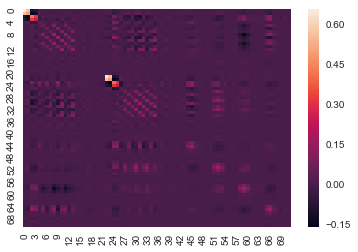

In [5]:
import seaborn as sns

sns.heatmap(P[0].reshape(dim, dim))

# Utilities 

In [8]:
from SCFInitialGuess.utilities.analysis import mf_initializer_damping as mf_initializer_standard

def mf_initializer(mol):
    mf = mf_initializer_standard(mol)
    mf.max_cycle = 1
    return mf

In [9]:
from SCFInitialGuess.utilities.analysis import make_results_str, measure_all_quantities
from SCFInitialGuess.utilities.dataset import StaticDataset

dataset = StaticDataset(
    #train=(s_train, p_train),
    train=(None, None),
    validation=(None, None),
    test=(s_test, p_test),
    mu=mu,
    std=std
)

In [10]:
print(make_results_str(measure_all_quantities(
    p_test,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
0.00000E+00 +- 0.00000E+00
--- Symmetry Error ---
0.00000E+00 +- 0.00000E+00
--- Idempotence Error ---
4.88457E+00 +- 6.96436E-01
--- Occupance Error ---
2.09329E+02 +- 8.93866E+00
--- HF Energy Error ---
4.25218E-13 +- 6.60038E-13
--- Avg. Iterations ---
1.00000E+00 +- 0.00000E+00
--- Avg. Iterations W/O Non Converged ---
1.00000E+00 +- 0.00000E+00
--- Num. Not Convd. ---
1001



# Pure blocks

i will now set all other elements zero

## Utilities

In [11]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

mol = molecules[1][0]

mask = np.zeros((dim, dim))

current_dim = 0
for atom in mol.species:
    
    # calculate block range
    index_start = current_dim
    current_dim += N_BASIS[basis][atom] 
    index_end = current_dim
    
    # calculate logical vector
    L = np.arange(dim)
    L = np.logical_and(index_start <= L, L < index_end)
    
    m = np.logical_and.outer(L, L)
    mask = np.logical_or(mask, m)
    
#mask

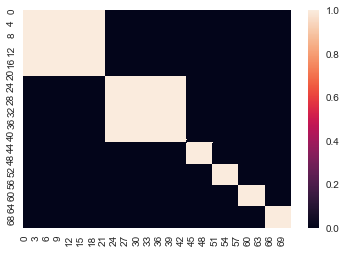

In [12]:
import seaborn as sns

sns.heatmap(mask.astype("int"))

In [13]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def extract_pure(p):
    p_batch = p.copy()
    p_batch[np.logical_not(mask)] = 0
    return p_batch

p_pure = np.array(list(map(extract_pure, p_test))).astype("float64")

In [14]:
np.save(data_path + subfolder + "p_pure.npy", p_pure)

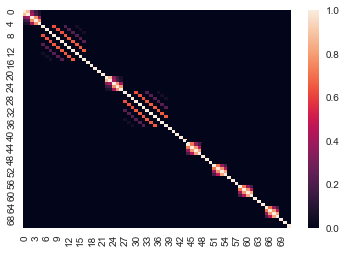

In [15]:
sns.heatmap(p_pure[0])

In [16]:
print(make_results_str(measure_all_quantities(
    p_pure,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
6.97951E-02 +- 4.47224E-02
--- Symmetry Error ---
0.00000E+00 +- 0.00000E+00
--- Idempotence Error ---
4.77943E-01 +- 2.37291E-02
--- Occupance Error ---
9.96635E+01 +- 0.00000E+00
--- HF Energy Error ---
4.12975E+03 +- 5.66403E+02
--- Avg. Iterations ---
1.00000E+00 +- 0.00000E+00
--- Avg. Iterations W/O Non Converged ---
1.00000E+00 +- 0.00000E+00
--- Num. Not Convd. ---
1001



# Embedding the Blocks In Classical Guesses

In [21]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def embedd(x, y):
    p = x.copy()
    p[mask] = (y.copy())[mask]
    return p

def embedd_batch(p_batch):
    p_embedded = []
    for (p_guess, p_conv) in zip(p_batch, p_test):
        p_embedded.append(embedd(p_guess, p_conv))
    return np.array(p_embedded)


## Convergedn in Converged 

In [22]:
p_test_test = embedd_batch(p_test)

In [23]:
print(make_results_str(measure_all_quantities(
    p_test_test,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
0.00000E+00 +- 0.00000E+00
--- Symmetry Error ---
0.00000E+00 +- 0.00000E+00
--- Idempotence Error ---
4.88457E+00 +- 6.96436E-01
--- Occupance Error ---
2.09329E+02 +- 8.93866E+00
--- HF Energy Error ---
4.00686E-13 +- 6.31579E-13
--- Avg. Iterations ---
9.98771E+01 +- 2.74633E+00
--- Avg. Iterations W/O Non Converged ---
1.00000E+02 +- 0.00000E+00
--- Num. Not Convd. ---
999



## H_core

In [ ]:
from pyscf.scf import hf

p_1e = np.array([ 
    hf.init_guess_by_1e(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")

In [ ]:
np.save(data_path + subfolder + "p_1e.npy", p_1e)

In [ ]:
print(make_results_str(measure_all_quantities(
    p_1e,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

## Embedd H_core

In [ ]:
p_embedded_1e = embedd_batch(p_1e)

In [ ]:
np.save(data_path + subfolder + "p_embedded_1e.npy", p_embedded_1e)

In [ ]:
print(make_results_str(measure_all_quantities(
    p_embedded_1e,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

In [ ]:
117/201

## GWH

In [ ]:
from pyscf.scf import hf

p_gwh = np.array([ 
    hf.init_guess_by_wolfsberg_helmholtz(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")

In [ ]:
np.save(data_path + subfolder + "p_gwh.npy", p_gwh)

In [ ]:
sns.heatmap(p_gwh[0])

In [ ]:
print(make_results_str(measure_all_quantities(
    p_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

In [ ]:
190/201

## Embedded GWH 

In [ ]:
p_embedded_gwh = embedd_batch(p_gwh)

In [ ]:
np.save(data_path + subfolder + "p_embedded_gwh.npy", p_embedded_gwh)

In [ ]:
sns.heatmap(p_embedded_gwh[0])

In [ ]:
print(make_results_str(measure_all_quantities(
    p_embedded_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

## SAD 

In [ ]:
from pyscf.scf import hf

p_sad = np.array([
    hf.init_guess_by_atom(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")

sns.heatmap(p_sad[0])

In [ ]:
sns.heatmap(np.abs(p_sad[0]-p_pure[0]))

In [ ]:
np.save(data_path + subfolder + "p_sad.npy", p_sad)

In [ ]:
print(make_results_str(measure_all_quantities(
    p_sad,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

## Embedded SAD

In [ ]:
p_embedded_sad = embedd_batch(p_sad)
sns.heatmap(p_embedded_sad[0])

In [ ]:
np.save(data_path + subfolder + "p_embedded_sad.npy", p_embedded_sad)

In [ ]:
print(make_results_str(measure_all_quantities(
    p_embedded_sad,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

In [ ]:
11/201

# McWheeny

In [ ]:
from SCFInitialGuess.nn.post_processing import multi_mc_wheeny

def multi_mc_wheeny_batch(p_batch):
    p_res = []
    for p, s in zip(p_batch, s_test):
        p_res.append(multi_mc_wheeny(p, s, 5))
    return np.asarray(p_res)

## GWH 

In [ ]:
p_embedded_gwh_mcw5 = multi_mc_wheeny_batch(p_embedded_gwh)

In [ ]:
np.save(data_path + subfolder + "p_embedded_gwh_mcw5.npy", p_embedded_gwh_mcw5)

In [ ]:
sns.heatmap(p_embedded_gwh_mcw5[0])

In [ ]:
print(make_results_str(measure_all_quantities(
    p_embedded_gwh_mcw5,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

In [ ]:
49/201

## SAD 

In [ ]:
p_embedded_sad_mcw5 = multi_mc_wheeny_batch(p_embedded_sad)

In [ ]:
np.save(data_path + subfolder + "p_embedded_sad_mcw5.npy", p_embedded_sad_mcw5)

In [ ]:
sns.heatmap(p_embedded_gwh_mcw5[0])

In [ ]:
print(make_results_str(measure_all_quantities(
    p_embedded_sad_mcw5,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

In [ ]:
114/201

# Embedd Outer 

In [ ]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def embedd_outer(x, y):
    p = x.copy()
    p[np.logical_not(mask)] = (y.copy())[np.logical_not(mask)]
    return p

def embedd_batch_outer(p_batch):
    p_embedded = []
    for (p_guess, p_conv) in zip(p_batch, p_test):
        p_embedded.append(embedd_outer(p_guess, p_conv))
    return np.array(p_embedded)

## Converged 

In [ ]:
print(make_results_str(measure_all_quantities(
    embedd_batch_outer(p_test),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

In [ ]:
print(make_results_str(measure_all_quantities(
    embedd_batch_outer(p_embedded_sad),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

## SAD 

In [ ]:
p_embedded_outer_sad = embedd_batch_outer(p_sad)
sns.heatmap(p_embedded_outer_sad[0])

In [ ]:
np.save(data_path + subfolder + "p_embedded_outer_sad.npy", p_embedded_outer_sad)

In [ ]:
print(make_results_str(measure_all_quantities(
    p_embedded_outer_sad,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

In [ ]:
68 / 201

## GWH 

In [ ]:
p_embedded_outer_gwh = embedd_batch_outer(p_gwh)
sns.heatmap(p_embedded_outer_gwh[0])

In [ ]:
np.save(data_path + subfolder + "p_embedded_outer_gwh.npy", p_embedded_outer_gwh)

In [ ]:
print(make_results_str(measure_all_quantities(
    p_embedded_outer_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

In [ ]:
194 / 201